### 1. Data Preparation & Cleaning

In [1]:
###%pip install tensorflow

In [1]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [2]:
# %% Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from pycaret.time_series import *
import optuna



In [ ]:




# %% Load Data
# Import data from a CSV file
df = pd.read_csv('data/individual_household_electric_power_consumption.csv', sep=',', 
                 parse_dates={'datetime': ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 low_memory=False, 
                 na_values=['?', 'nan'])
df.drop(['Unnamed: 0'], axis=1, inplace=True)  # Drop the unnamed column if it exists
# Set datetime index
df.set_index('datetime', inplace=True)

In [19]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [4]:
# Check missing values (1.25% missing)
print(f"Missing values: {df.isna().sum().sum()}")

Missing values: 181853


In [5]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np

# resample to the hourly frequency and fill missing values with forward fill method
data = df.resample('H').mean().ffill()

# Check stationarity with ADF test
result = adfuller(data['Global_active_power'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

if result[1] > 0.05:
    print("Data is non-stationary. Applying transformations...")
    # Differencing
    data['differenced'] = data['Global_active_power'] - data['Global_active_power'].shift(1)
    
    # Recheck stationarity
    result_diff = adfuller(data['differenced'].dropna())
    print(f"After Differencing - ADF Statistic: {result_diff[0]}")
    print(f"P-Value: {result_diff[1]}")
else:
    print("Data is already stationary!")



ADF Statistic: -14.284291292018834
P-Value: 1.30791848044184e-26
Data is already stationary!


In [8]:
# Interpolate missing values (time-series-friendly method)
df.interpolate(method='time', inplace=True)
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [9]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [10]:
# Resample to hourly data (reduce granularity)
hourly_df = df.resample('H').mean()
#hourly_df['Global_active_power'].fillna(method='ffill', inplace=True)  # Forward-fill if needed

# Save cleaned data
#hourly_df.to_csv('hourly_power_consumption.csv')

In [11]:
hourly_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


In [30]:
hourly_df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

2. Exploratory Data Analysis (EDA)

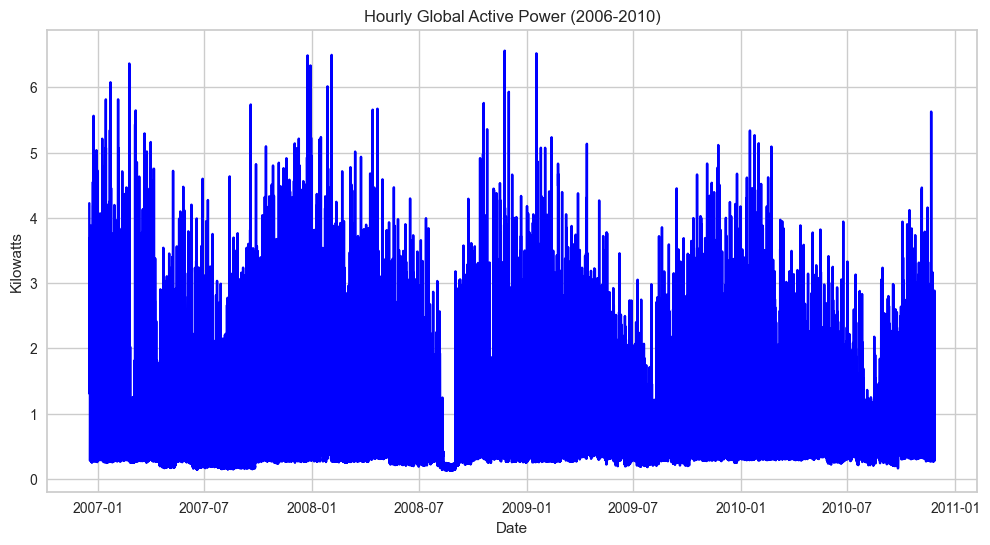

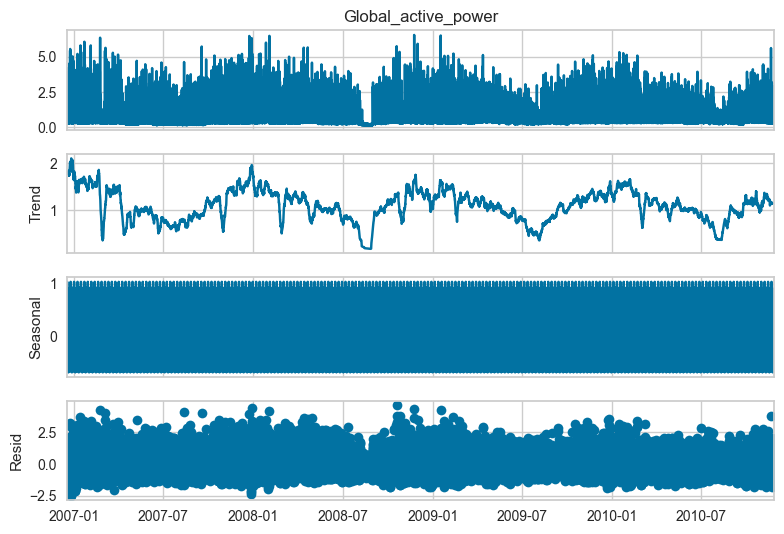

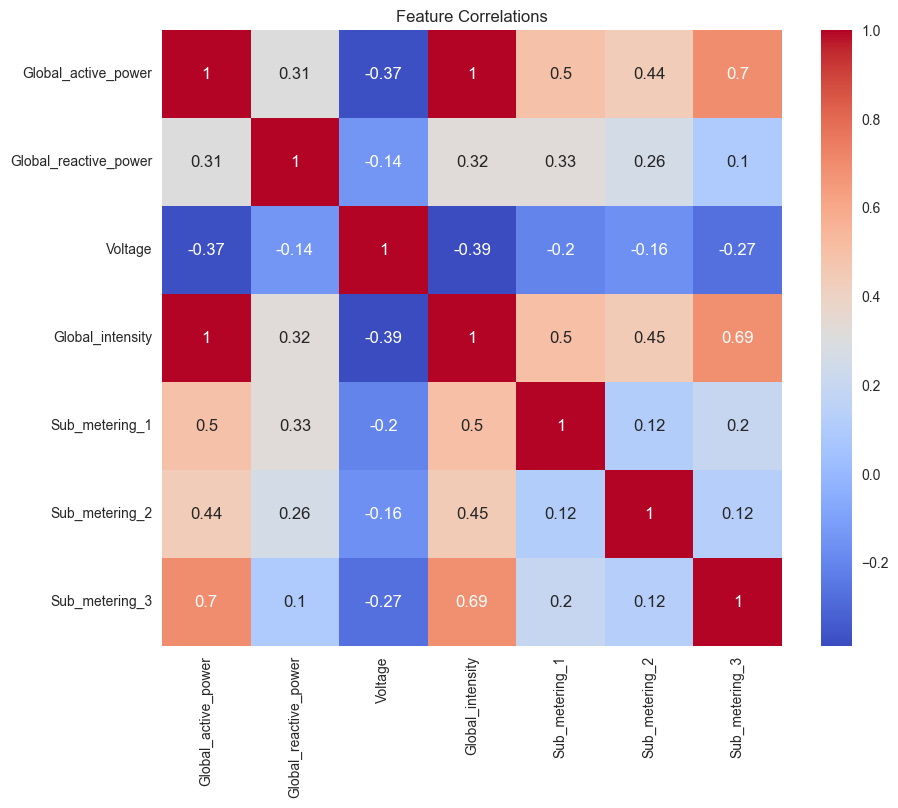

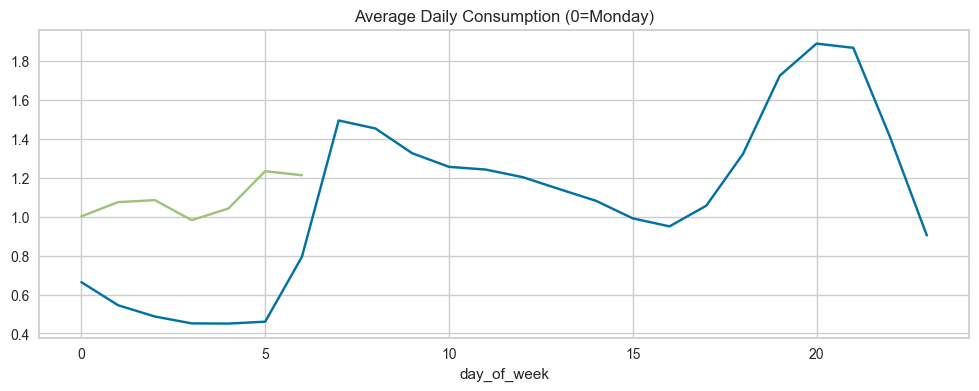

In [12]:
import seaborn as sns
# %% Plot Time Series
plt.figure(figsize=(12, 6))
plt.plot(hourly_df.index, hourly_df['Global_active_power'], color='blue')
plt.title('Hourly Global Active Power (2006-2010)')
plt.xlabel('Date')
plt.ylabel('Kilowatts')
plt.show()

# %% Seasonal Decomposition (Daily/Weekly Seasonality)
decomposition = seasonal_decompose(hourly_df['Global_active_power'], period=24*7)  # Weekly seasonality
decomposition.plot()
plt.show()

# %% Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(hourly_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

# %% Daily and Hourly Patterns
hourly_df['hour'] = hourly_df.index.hour
hourly_df['day_of_week'] = hourly_df.index.dayofweek

daily_pattern = hourly_df.groupby('hour')['Global_active_power'].mean()
weekly_pattern = hourly_df.groupby('day_of_week')['Global_active_power'].mean()

plt.figure(figsize=(12, 4))
daily_pattern.plot(title='Average Hourly Consumption')
weekly_pattern.plot(title='Average Daily Consumption (0=Monday)')
plt.show()

3. Model Development
3.1 Baseline Models

In [13]:
# Split data into train/test (e.g., 80-20 split)
train_size = int(len(hourly_df) * 0.8)
train, test = hourly_df.iloc[:train_size], hourly_df.iloc[train_size:]

# Naive Forecast (last observation)
naive_forecast = test['Global_active_power'].shift(1).fillna(train['Global_active_power'].iloc[-1])
mae_naive = mean_absolute_error(test['Global_active_power'], naive_forecast)
print(f"Naive MAE: {mae_naive:.2f}")

# Moving Average (7-day window)
window = 24 * 7  # Weekly window
rolling_mean = train['Global_active_power'].rolling(window=window).mean()
ma_forecast = test['Global_active_power'].shift(1).fillna(rolling_mean.iloc[-1])
mae_ma = mean_absolute_error(test['Global_active_power'], ma_forecast)
print(f"Moving Average MAE: {mae_ma:.2f}")

Naive MAE: 0.38
Moving Average MAE: 0.38


3.2 ARIMA/SARIMA

In [14]:
# Check stationarity
result = adfuller(train['Global_active_power'])
print(f"ADF p-value: {result[1]}")  # If >0.05, apply differencing

# Auto-ARIMA (uncomment if pmdarima is installed)
# from pmdarima import auto_arima
# model_auto = auto_arima(train['Global_active_power'], seasonal=True, m=24)
# print(model_auto.summary())

# Manual SARIMA
model_sarima = SARIMAX(train['Global_active_power'], 
                      order=(1, 1, 1), 
                      seasonal_order=(1, 1, 1, 24),
                      low_memory=True)
results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.forecast(steps=len(test))
mae_sarima = mean_absolute_error(test['Global_active_power'], forecast_sarima)
print(f"SARIMA MAE: {mae_sarima:.2f}")

ADF p-value: 1.2947518628862546e-23
SARIMA MAE: 0.82


3.3 RNN (LSTM)

In [ ]:
# Prepare sequences for LSTM
def create_sequences(data, n_steps=10):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 24  # 24-hour window
X_train, y_train = create_sequences(train['Global_active_power'].values, n_steps)
X_test, y_test = create_sequences(test['Global_active_power'].values, n_steps)

# Build LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# Train
history = model_lstm.fit(X_train, y_train, 
                        epochs=20, 
                        batch_size=36, 
                        learning_rate=0.001,
                        validation_data=(X_test, y_test), 
                       callbacks=[EarlyStopping(patience=3)]
                       )

# Predict
forecast_lstm = model_lstm.predict(X_test)
mae_lstm = mean_absolute_error(y_test, forecast_lstm)
print(f"LSTM MAE: {mae_lstm:.2f}")

Epoch 1/20
768/768 [==============================] - 8s 9ms/step - loss: 0.4897 - val_loss: 0.2708
Epoch 2/20
768/768 [==============================] - 8s 10ms/step - loss: 0.3791 - val_loss: 0.2602
Epoch 3/20
768/768 [==============================] - 7s 9ms/step - loss: 0.3697 - val_loss: 0.2560
Epoch 4/20
768/768 [==============================] - 8s 10ms/step - loss: 0.3650 - val_loss: 0.2562
Epoch 5/20
768/768 [==============================] - 8s 10ms/step - loss: 0.3625 - val_loss: 0.2575
Epoch 6/20
768/768 [==============================] - 8s 11ms/step - loss: 0.3594 - val_loss: 0.2552
Epoch 7/20
768/768 [==============================] - 8s 11ms/step - loss: 0.3577 - val_loss: 0.2540
Epoch 8/20
768/768 [==============================] - 8s 10ms/step - loss: 0.3565 - val_loss: 0.2522
Epoch 9/20
768/768 [==============================] - 9s 11ms/step - loss: 0.3540 - val_loss: 0.2538
Epoch 10/20
768/768 [==============================] - 8s 11ms/step - loss: 0.3536 - val_loss

3.4 AutoML with PyCaret

In [20]:
# Setup PyCaret
setup = setup(data=hourly_df[['Global_active_power']], 
             target='Global_active_power', 
             fold_strategy='sliding', 
             session_id=42)

# Compare models
best_model = compare_models(sort='MAE')

# Create and tune best model
model = create_model(best_model)
tuned_model = tune_model(model)


# Evaluate
predict_model(tuned_model)

,Description,Value
0,session_id,42
1,Target,Global_active_power
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(34589, 1)"
5,Transformed data shape,"(34589, 1)"
6,Transformed train set shape,"(34588, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,SlidingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
naive,Naive Forecaster,0.3837,0.2576,0.2446,0.2446,0.1915,0.1656,2.9200
croston,Croston,0.4319,0.2900,0.2754,0.2754,0.1845,0.1957,0.0433
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.5160,0.3464,0.3290,0.3290,0.2577,0.2247,0.2900
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.5160,0.3464,0.3290,0.3290,0.2577,0.2247,0.1767
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.5160,0.3464,0.3290,0.3290,0.2577,0.2247,0.1800
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.5399,0.3625,0.3442,0.3442,0.2621,0.2205,0.1933
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.5684,0.3816,0.3624,0.3624,0.2737,0.2303,0.2567
grand_means,Grand Means Forecaster,0.5886,0.3952,0.3753,0.3753,0.2378,0.2807,1.4733
arima,ARIMA,0.6073,0.4077,0.3872,0.3872,0.2493,0.2105,12.4667
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.6212,0.4171,0.3961,0.3961,0.2957,0.2482,14.6567


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2010-11-26 17:00,0.2391,0.1605,0.1524,0.1524,0.0969,0.0924
1,2010-11-26 18:00,0.1347,0.0904,0.0859,0.0859,0.0517,0.0531
2,2010-11-26 19:00,0.7774,0.5219,0.4956,0.4956,0.4259,0.3511
Mean,NaT,0.3837,0.2576,0.2446,0.2446,0.1915,0.1656
SD,NaT,0.2816,0.1891,0.1795,0.1795,0.1668,0.1322


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2010-11-26 17:00,0.2390,0.1604,0.1524,0.1524,0.0968,0.0924
1,2010-11-26 18:00,0.1348,0.0905,0.0859,0.0859,0.0518,0.0532
2,2010-11-26 19:00,0.7773,0.5219,0.4956,0.4956,0.4259,0.3511
Mean,NaT,0.3837,0.2576,0.2446,0.2446,0.1915,0.1655
SD,NaT,0.2816,0.1890,0.1795,0.1795,0.1667,0.1322


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,Naive Forecaster,0.3592,0.2412,0.2290,0.2290,0.2450,0.2183


,y_pred
2010-11-26 21:00,1.1637


In [21]:
predict_model(tuned_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,Naive Forecaster,0.3592,0.2412,0.2290,0.2290,0.2450,0.2183


,y_pred
2010-11-26 21:00,1.1637


4. Hyperparameter Tuning with Optuna (Example for SARIMA)

In [22]:
def objective(trial):
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    model = SARIMAX(train['Global_active_power'], order=(p, d, q))
    results = model.fit()
    forecast = results.forecast(steps=len(test))
    return mean_absolute_error(test['Global_active_power'], forecast)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print(f"Best SARIMA params: {study.best_params}")

[I 2025-04-28 13:14:32,379] A new study created in memory with name: no-name-cc9df9f8-d295-4084-a650-d21c6dafdeed
[I 2025-04-28 13:14:35,954] Trial 0 finished with value: 0.7655142001735646 and parameters: {'p': 1, 'd': 1, 'q': 3}. Best is trial 0 with value: 0.7655142001735646.
[I 2025-04-28 13:14:38,329] Trial 1 finished with value: 1.0028895608898178 and parameters: {'p': 2, 'd': 0, 'q': 1}. Best is trial 0 with value: 0.7655142001735646.
[I 2025-04-28 13:14:40,194] Trial 2 finished with value: 1.056142643558669 and parameters: {'p': 0, 'd': 2, 'q': 1}. Best is trial 0 with value: 0.7655142001735646.
[I 2025-04-28 13:14:40,742] Trial 3 finished with value: 508.0395508766819 and parameters: {'p': 1, 'd': 2, 'q': 0}. Best is trial 0 with value: 0.7655142001735646.
[I 2025-04-28 13:14:41,019] Trial 4 finished with value: 177.0607666064023 and parameters: {'p': 0, 'd': 2, 'q': 0}. Best is trial 0 with value: 0.7655142001735646.
[I 2025-04-28 13:14:48,144] Trial 5 finished with value: 1.

Best SARIMA params: {'p': 3, 'd': 1, 'q': 3}


5. Final Evaluation

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,Naive Forecaster,0.3592,0.2412,0.2290,0.2290,0.2450,0.2183


                  y_pred
2010-11-26 21:00  1.1637


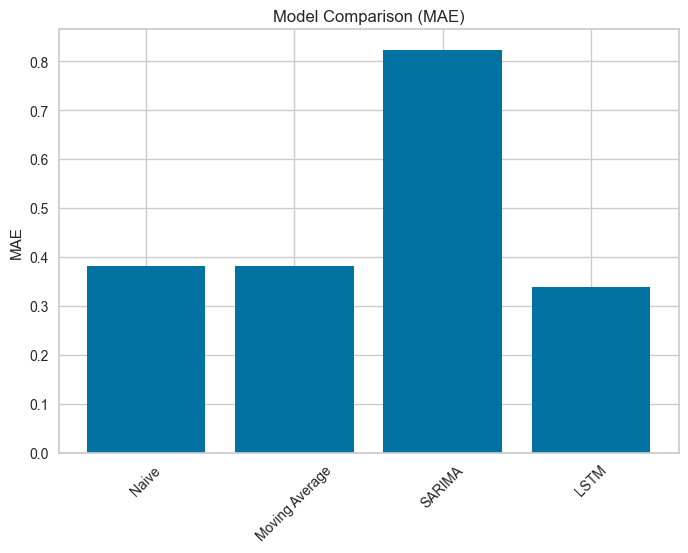

In [ ]:
# Evaluate PyCaret model
pycaret_results = predict_model(tuned_model)
print(pycaret_results)  # Check the output structure

# Extract MAE (adjust key based on actual output)
#mae_pycaret = pycaret_results['MAE'].iloc[0]  # or ['mae'], ['Mean Absolute Error'], etc.

metrics = {
    'Naive': mae_naive,
    'Moving Average': mae_ma,
    'SARIMA': mae_sarima,
    'LSTM': mae_lstm,
    #'PyCaret AutoML': mae_pycaret
    
}

# Plot
plt.bar(metrics.keys(), metrics.values())
plt.title('Model Comparison (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.show()